# Inference and Validation 

- to evaluate validation score 

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- argparser
parser = argparse.ArgumentParser()
parser.add_argument('--cfg', type=str, default='./configs/finetune_6.yaml')
ckpt_path = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/16_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_MSE_tensor_epoch_12.pth"

args = parser.parse_args(args=[])
cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))

In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
if cfg.TIMM: 
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )
    
    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    #logger.info(data_config)
    #logger.info(data_transform)

print("#--- run version : ", cfg.RUN_VERSION)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#--- run version :  16


In [5]:
model.load_state_dict(torch.load(ckpt_path))

<All keys matched successfully>

In [6]:
train_set = map_dataset.Map_Dataset_v5(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v5(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

In [7]:
print(train_set.__getitem__(0)[0].shape)
print(train_set.__getitem__(0)[1])

torch.Size([3, 448, 448])
0


Label :  4
Prediction :  tensor([0], device='cuda:3')


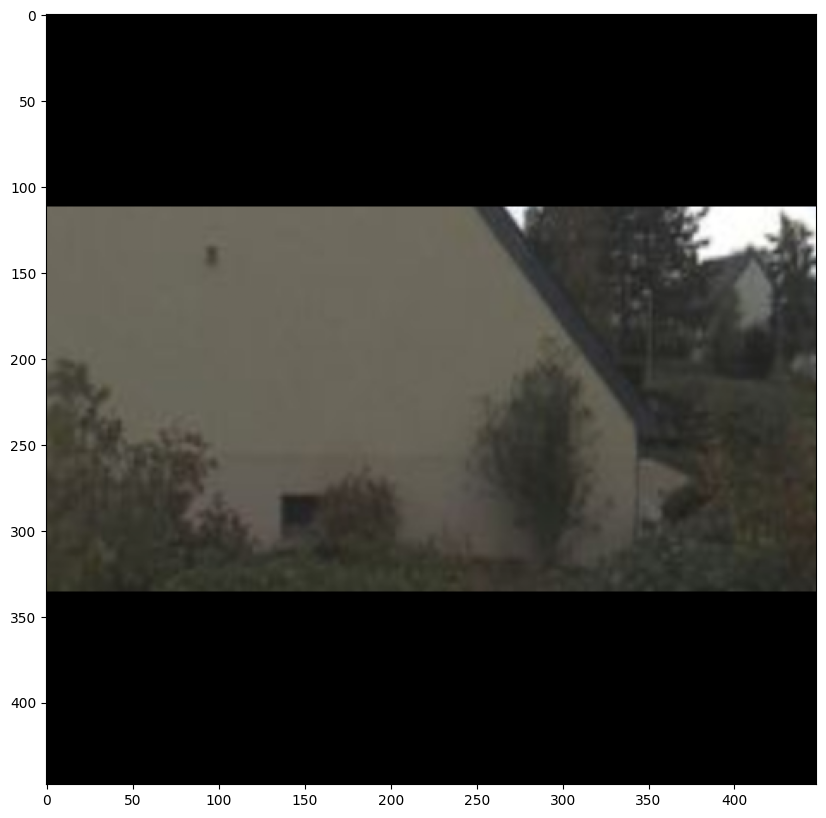

In [8]:
#--- Single image for Visualization 

import random
idx_ = random.randint(0,999)
img_torch = train_set.__getitem__(idx_)[0]
RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"

model = model.to(device)
img_torch = img_torch.to(device)
model.eval()
img_torch = img_torch.unsqueeze(0)
preds = model(img_torch)
preds = preds.argmax(1)

print("Label : ",train_set.__getitem__(idx_)[1])
print("Prediction : ", preds)

In [9]:
batch_size = 8
TrainLoader = DataLoader(train_set,batch_size)
ValidLoader = DataLoader(valid_set,batch_size,shuffle=False)

In [49]:
'''
CE models 

'''

from tqdm import tqdm


loss_fn = "MSE"
device = "cuda:3"
model = model.to(device)

#-- Loader train/valid
Loader = ValidLoader
#--
labels_ = []
predictions_ = []
print("LOSS FN : ", loss_fn)
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    lables = batch[1]
    batch_preds = model(imgs)
    
    
    if loss_fn == "CE":  
        predictions = torch.argmax(batch_preds,-1).detach().cpu().numpy()
    else:
        predictions = batch_preds.detach().cpu().numpy()
    
    # #-- 
    predictions_.extend(predictions)
    labels_.extend(lables)
    
#-- memory clean 
torch.cuda.empty_cache()

LOSS FN :  MSE


100%|██████████| 386/386 [01:32<00:00,  4.17it/s]


In [50]:
len(labels_)

3085

In [51]:
len(predictions_)

3085

In [52]:
labels_

[tensor(5),
 tensor(2),
 tensor(5),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(3),
 tensor(5),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(1),
 tensor(5),
 tensor(3),
 tensor(0),
 tensor(2),
 tensor(4),
 tensor(6),
 tensor(5),
 tensor(4),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(5),
 tensor(0),
 tensor(2),
 tensor(0),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(0),
 tensor(1),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(3),
 tensor(0),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(4),
 tensor(3),
 tensor(5),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(2),
 tensor(1),
 tensor(5),
 tensor(4),
 tensor(5),
 tensor(1),
 tensor(6),
 tensor(6),
 tensor(6),
 tensor(3),
 tensor(1),
 tensor(2),
 tensor(3),
 tensor(6),
 tensor(4),
 tensor(3),
 tensor(3),
 tensor(0),
 tensor(0),
 tensor(6),
 tensor(1),
 tensor(0),
 tensor(0),
 tensor(5),
 ten

In [53]:
predictions_

[array([4.790959], dtype=float32),
 array([2.2643194], dtype=float32),
 array([4.5676003], dtype=float32),
 array([0.7381844], dtype=float32),
 array([1.042967], dtype=float32),
 array([0.3364115], dtype=float32),
 array([3.1602087], dtype=float32),
 array([4.0100346], dtype=float32),
 array([2.4114816], dtype=float32),
 array([0.05553951], dtype=float32),
 array([6.0116415], dtype=float32),
 array([3.4936616], dtype=float32),
 array([5.955583], dtype=float32),
 array([1.7382886], dtype=float32),
 array([1.6362495], dtype=float32),
 array([5.077273], dtype=float32),
 array([2.0935714], dtype=float32),
 array([3.3205013], dtype=float32),
 array([0.27743956], dtype=float32),
 array([0.02809595], dtype=float32),
 array([1.3275154], dtype=float32),
 array([4.7782993], dtype=float32),
 array([5.397214], dtype=float32),
 array([5.57346], dtype=float32),
 array([4.8224626], dtype=float32),
 array([0.01984866], dtype=float32),
 array([2.1544464], dtype=float32),
 array([5.954313], dtype=float3

In [71]:
trans_predictions_ = np.trunc(predictions_)

In [72]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(labels_, trans_predictions_, average='weighted')
accuracy = accuracy_score(labels_, trans_predictions_)

In [73]:
precision

0.555405930362582

In [74]:
recall

0.5319286871961102

In [75]:
f1

0.5272399376317348

In [76]:
accuracy

0.5319286871961102

In [21]:
torch.cuda.empty_cache()